In [9]:
import pandas as pd

# Correct path style
df = pd.read_csv(r"C:\Users\HP\Desktop\ai\archive\creditcard.csv")

# Show the first few rows
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


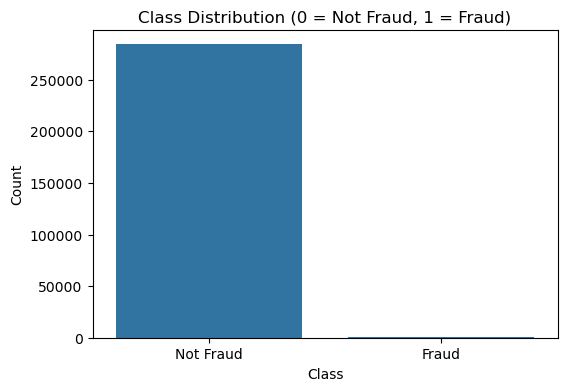

Class counts:
 Class
0    284315
1       492
Name: count, dtype: int64

Fraud percentage: 0.17275%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each class
class_counts = df['Class'].value_counts()

# Plot the class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution (0 = Not Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.show()

# Print exact counts and percentage
print("Class counts:\n", class_counts)
print("\nFraud percentage: {:.5f}%".format((class_counts[1] / class_counts.sum()) * 100))

In [13]:
from sklearn.preprocessing import StandardScaler

# Separate fraud and non-fraud
fraud_df = df[df['Class'] == 1].copy()
nonfraud_df = df[df['Class'] == 0].copy()

# Drop 'Time' and 'Class' columns for GAN input
fraud_data = fraud_df.drop(['Time', 'Class'], axis=1)

# Normalize features
scaler = StandardScaler()
fraud_data_scaled = scaler.fit_transform(fraud_data)

print("Fraud data shape (for GAN training):", fraud_data_scaled.shape)


Fraud data shape (for GAN training): (492, 29)


In [15]:
!pip install torch torchvision

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 1.4 MB/s eta 0:00:02
   - -------------------------------------- 0.1/1.7 MB 991.0 kB/s eta 0:00:02
   -- ------------------------------------- 0.1/1.7 MB 751.6 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.7 MB 751.6 kB/s eta 0:00:03
   ----- ---------------------------------- 0.2/1.7 MB 986.4 kB/s eta 0:00:02
   ----- ---------------------------------- 0.2/1.7 MB 986.4 kB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.7 MB 951.8 kB/s eta 0:00:02
   --------- ------------------------------ 0.4/1.7 MB 1.1 MB/s eta 0:00:02
   ---------- ----------------------------- 0.5/1.7 MB 1.1 MB/s eta 0:00:02
   --------------- ------------------------ 0.7/1.7 MB 1.4 MB/s eta 0:00:01
   ---------------- ----------------------- 0.7/1.7 MB 1.4 MB/s eta 0:00:01
   -------------------- ------------------- 0.9/1.7 MB 1.6 MB/s eta 0:00:01
   ----

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Generator
class Generator(nn.Module):
    def __init__(self, noise_dim, data_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, data_dim),
        )

    def forward(self, z):
        return self.model(z)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, data_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)


In [19]:
import numpy as np

# Convert data to torch tensors
fraud_tensor = torch.tensor(fraud_data_scaled, dtype=torch.float32).to(device)

# Hyperparameters
noise_dim = 16
data_dim = fraud_tensor.shape[1]
batch_size = 64
epochs = 3000  # reduce to 1000 if you're in a hurry
lr = 0.0002

# Initialize models
G = Generator(noise_dim, data_dim).to(device)
D = Discriminator(data_dim).to(device)

# Optimizers
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

# Loss
loss_fn = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    # === Train Discriminator ===
    # Real samples
    idx = np.random.randint(0, fraud_tensor.shape[0], batch_size)
    real_samples = fraud_tensor[idx]
    real_labels = torch.ones((batch_size, 1)).to(device)

    # Fake samples
    z = torch.randn((batch_size, noise_dim)).to(device)
    fake_samples = G(z)
    fake_labels = torch.zeros((batch_size, 1)).to(device)

    # Discriminator loss
    D_real = D(real_samples)
    D_fake = D(fake_samples.detach())
    D_loss = loss_fn(D_real, real_labels) + loss_fn(D_fake, fake_labels)

    optimizer_D.zero_grad()
    D_loss.backward()
    optimizer_D.step()

    # === Train Generator ===
    z = torch.randn((batch_size, noise_dim)).to(device)
    generated = G(z)
    G_loss = loss_fn(D(generated), real_labels)

    optimizer_G.zero_grad()
    G_loss.backward()
    optimizer_G.step()

    # Logging
    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {D_loss.item():.4f} | G Loss: {G_loss.item():.4f}")


Epoch 0 | D Loss: 1.3582 | G Loss: 0.7538
Epoch 500 | D Loss: 0.9764 | G Loss: 0.9172
Epoch 1000 | D Loss: 1.3867 | G Loss: 0.6797
Epoch 1500 | D Loss: 1.2599 | G Loss: 0.9971
Epoch 2000 | D Loss: 1.2918 | G Loss: 0.8181
Epoch 2500 | D Loss: 1.2436 | G Loss: 0.9728


In [21]:
# Number of synthetic samples to generate (same as real fraud count)
n_to_generate = len(fraud_df)

# Generate noise
z = torch.randn((n_to_generate, noise_dim)).to(device)

# Generate synthetic fraud data
G.eval()  # set Generator to evaluation mode
synthetic_fraud = G(z).detach().cpu().numpy()

# Inverse transform (undo the StandardScaler)
synthetic_fraud_original = scaler.inverse_transform(synthetic_fraud)

# Convert to DataFrame and add 'Class' column
synthetic_fraud_df = pd.DataFrame(synthetic_fraud_original, columns=fraud_data.columns)
synthetic_fraud_df['Class'] = 1  # label as fraud

# Preview
synthetic_fraud_df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,19.636774,-4.467759,4.385098,-1.265043,17.279394,-3.039518,10.254689,-6.669703,2.233364,1.450645,...,2.903098,-3.523569,-2.812862,-0.846676,3.449915,-0.710340,4.041233,1.266802,244.233200,1
1,10.880509,-0.379373,1.452467,-0.253505,14.256051,-2.650108,7.951565,-4.376882,0.724945,0.045208,...,1.721274,-3.043785,-2.499329,-0.700292,2.890713,-0.420552,2.991224,1.088652,123.517120,1
2,-9.932664,3.387149,-1.066261,2.019807,-5.693536,0.588178,-5.555521,2.352346,1.170719,-1.150474,...,-2.068282,0.272298,0.787683,0.622244,-0.862317,-1.449992,-0.601593,-0.166117,274.794739,1
3,10.796225,0.978354,5.753933,-0.297261,5.156282,-0.712554,-3.776547,-10.579365,1.213354,0.254947,...,0.924495,-0.802577,-2.153552,-1.003890,-0.300074,-0.434667,0.916240,1.192276,120.452087,1
4,6.315960,-0.489347,-2.149689,8.651706,-4.676553,-2.379575,-9.858542,6.216453,-0.895687,-8.911283,...,-2.983869,-0.138266,-1.907209,-0.353822,1.713870,-0.193367,1.066656,0.825776,157.816986,1


In [23]:
# Prepare real non-fraud data
nonfraud_data = nonfraud_df.drop(['Time', 'Class'], axis=1)
nonfraud_scaled = scaler.transform(nonfraud_data)
nonfraud_df_scaled = pd.DataFrame(nonfraud_scaled, columns=nonfraud_data.columns)
nonfraud_df_scaled['Class'] = 0

# Use original + synthetic fraud data
augmented_df = pd.concat([nonfraud_df_scaled, synthetic_fraud_df], axis=0).sample(frac=1, random_state=42)

# Final balanced dataset
print("Final class distribution:\n", augmented_df['Class'].value_counts())
augmented_df.head()

Final class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,0.875575,-1.104163,1.107761,-1.787510,0.294213,0.603087,0.619954,-0.061988,0.974651,1.277939,...,-0.070307,0.649013,-0.056025,0.347260,0.277736,-0.158115,-0.104987,-0.076563,-0.090520,0
49906,0.293563,-1.190099,1.254505,-1.658328,0.520947,0.622355,0.808389,-0.130083,0.813463,1.367201,...,-0.284666,-0.032297,-0.581618,0.898335,0.334335,-1.083600,-0.798176,-1.027088,0.122020,0
29474,0.867839,-0.847832,1.169771,-1.135053,0.455148,0.911137,0.694136,-0.058333,1.329709,1.104213,...,-0.190628,0.138041,0.033869,0.419919,0.418480,-0.922141,-0.054820,-0.070504,-0.437643,0
276481,0.692347,-0.566703,0.912549,-1.798078,0.762410,0.317726,0.904495,-0.097630,1.094332,1.053666,...,-0.283112,-0.597395,0.079695,1.116250,-0.499326,0.153248,0.116972,0.122080,-0.469621,0
278846,0.551233,-0.777008,1.183015,-1.882661,0.640089,0.353044,0.783520,-0.076255,1.381566,1.057204,...,-0.139570,0.591170,-0.146457,0.121625,-0.188424,0.129238,0.267730,0.440538,-0.419937,0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare original dataset
X_orig = df.drop(['Time', 'Class'], axis=1)
X_orig_scaled = scaler.fit_transform(X_orig)
y_orig = df['Class']

# Train/test split
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_orig_scaled, y_orig, test_size=0.2, random_state=42)

# Train classifier
clf_orig = RandomForestClassifier(n_estimators=100, random_state=42)
clf_orig.fit(X_train_o, y_train_o)

# Evaluate
y_pred_o = clf_orig.predict(X_test_o)
print("Original Imbalanced Dataset")
print(confusion_matrix(y_test_o, y_pred_o))
print(classification_report(y_test_o, y_pred_o, digits=4))


Original Imbalanced Dataset
[[56862     2]
 [   23    75]]
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     56864
           1     0.9740    0.7653    0.8571        98

    accuracy                         0.9996     56962
   macro avg     0.9868    0.8826    0.9285     56962
weighted avg     0.9996    0.9996    0.9995     56962



In [27]:
# Prepare balanced dataset
X_aug = augmented_df.drop('Class', axis=1)
y_aug = augmented_df['Class']

# Train/test split
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)

# Train classifier
clf_aug = RandomForestClassifier(n_estimators=100, random_state=42)
clf_aug.fit(X_train_a, y_train_a)

# Evaluate
y_pred_a = clf_aug.predict(X_test_a)
print("Balanced Dataset with Vanilla GAN")
print(confusion_matrix(y_test_a, y_pred_a))
print(classification_report(y_test_a, y_pred_a, digits=4))


Balanced Dataset with Vanilla GAN
[[56866     0]
 [    0    96]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     56866
           1     1.0000    1.0000    1.0000        96

    accuracy                         1.0000     56962
   macro avg     1.0000    1.0000    1.0000     56962
weighted avg     1.0000    1.0000    1.0000     56962



In [29]:
class WGAN_Generator(nn.Module):
    def __init__(self, noise_dim, data_dim):
        super(WGAN_Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, data_dim)
        )

    def forward(self, z):
        return self.model(z)

class WGAN_Critic(nn.Module):
    def __init__(self, data_dim):
        super(WGAN_Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(data_dim, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


In [31]:
noise_dim = 16
data_dim = fraud_tensor.shape[1]
batch_size = 64
epochs = 2000
lr = 0.00005
clip_value = 0.01
n_critic = 5

G_wgan = WGAN_Generator(noise_dim, data_dim).to(device)
C_wgan = WGAN_Critic(data_dim).to(device)

optimizer_G = optim.RMSprop(G_wgan.parameters(), lr=lr)
optimizer_C = optim.RMSprop(C_wgan.parameters(), lr=lr)

for epoch in range(epochs):
    for _ in range(n_critic):
        idx = np.random.randint(0, fraud_tensor.shape[0], batch_size)
        real_samples = fraud_tensor[idx]

        z = torch.randn((batch_size, noise_dim)).to(device)
        fake_samples = G_wgan(z).detach()

        loss_C = -torch.mean(C_wgan(real_samples)) + torch.mean(C_wgan(fake_samples))

        optimizer_C.zero_grad()
        loss_C.backward()
        optimizer_C.step()

        for p in C_wgan.parameters():
            p.data.clamp_(-clip_value, clip_value)

    z = torch.randn((batch_size, noise_dim)).to(device)
    fake_samples = G_wgan(z)
    loss_G = -torch.mean(C_wgan(fake_samples))

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Critic Loss: {loss_C.item():.4f} | Gen Loss: {loss_G.item():.4f}")


Epoch 0 | Critic Loss: -0.0003 | Gen Loss: 0.0104
Epoch 500 | Critic Loss: -0.0088 | Gen Loss: 0.0107
Epoch 1000 | Critic Loss: -0.0072 | Gen Loss: 0.0100
Epoch 1500 | Critic Loss: -0.0047 | Gen Loss: 0.0089


In [33]:
G_wgan.eval()
z = torch.randn((len(fraud_df), noise_dim)).to(device)
synthetic_fraud_wgan = G_wgan(z).detach().cpu().numpy()

synthetic_fraud_wgan_original = scaler.inverse_transform(synthetic_fraud_wgan)

synthetic_fraud_wgan_df = pd.DataFrame(synthetic_fraud_wgan_original, columns=fraud_data.columns)
synthetic_fraud_wgan_df['Class'] = 1


In [35]:
augmented_wgan_df = pd.concat([nonfraud_df_scaled, synthetic_fraud_wgan_df], axis=0).sample(frac=1, random_state=42)

print("WGAN Balanced Class Counts:\n", augmented_wgan_df['Class'].value_counts())


WGAN Balanced Class Counts:
 Class
0    284315
1       492
Name: count, dtype: int64


In [37]:
X_wgan = augmented_wgan_df.drop('Class', axis=1)
y_wgan = augmented_wgan_df['Class']

X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wgan, y_wgan, test_size=0.2, random_state=42)

clf_wgan = RandomForestClassifier(n_estimators=100, random_state=42)
clf_wgan.fit(X_train_w, y_train_w)

y_pred_w = clf_wgan.predict(X_test_w)
print("Balanced Dataset with WGAN")
print(confusion_matrix(y_test_w, y_pred_w))
print(classification_report(y_test_w, y_pred_w, digits=4))


Balanced Dataset with WGAN
[[56866     0]
 [    1    95]]
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     56866
           1     1.0000    0.9896    0.9948        96

    accuracy                         1.0000     56962
   macro avg     1.0000    0.9948    0.9974     56962
weighted avg     1.0000    1.0000    1.0000     56962

